## An AI model to predict the water quality.
To train the model, we need a water quality dataset. A commonly used dataset is the UCI Water Quality Dataset. But since it is not available in Kaggle, we will use a synthetic dataset. It will have the following columns:

- pH
- Turbidity
- Temperature
- Classification: Potable (1) or Not Potable (0)

Since we are using a dataset that is not available in Kaggle, we will use a synthetic dataset. 

In [3]:
import pandas as pd
import numpy as np

# Function to generate synthetic water quality data
def generate_synthetic_data(n_samples=1000):
    data = {
        "pH": np.random.uniform(4, 10, n_samples),  # Random values between 4 and 10
        "Turbidity": np.random.uniform(0, 15, n_samples),  # Random turbidity values
        "Temperature": np.random.uniform(5, 40, n_samples),  # Random temperature values
    }

    df = pd.DataFrame(data)

    # Define potability based on standards
    df["Potability"] = df.apply(
        lambda row: 1 if (6.5 <= row["pH"] <= 8.5 and row["Turbidity"] <= 5 and 10 <= row["Temperature"] <= 30)
        else 0,
        axis=1,
    )

    return df

# Generate synthetic data
synthetic_data = generate_synthetic_data()

# Save to a CSV file for later use
synthetic_data.to_csv("synthetic_water_quality.csv", index=False)

print("Synthetic data generated and saved as 'synthetic_water_quality.csv'.")


Synthetic data generated and saved as 'synthetic_water_quality.csv'.


# Create a AI model to predict water quality

The dataset is available in the file `synthetic_water_quality.csv`. The dataset has the following columns:

- pH
- Turbidity
- Temperature

The target column is:

- Classification: Potable (1) or Not Potable (0)
  
## Required Libraries

```
pip install pandas numpy scikit-learn matplotlib seaborn
```

#### We have built a model that predicts water quality based on the pH, Turbidity, and Temperature of the water. The model is trained using a synthetic dataset. It is a basic Support Vector Machine (SVM) model

In [4]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Load the dataset
# Replace 'water_quality.csv' with your dataset's path
data = pd.read_csv("synthetic_water_quality.csv")

# Step 2: Preprocess the data
# Drop rows with missing values
data = data.dropna()

# Define features and target
X = data[['pH', 'Turbidity', 'Temperature']]  # Replace/add more features as needed
y = data['Potability']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 3: Train the SVM model
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

# Step 4: Evaluate the model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Save the model for later use
import joblib
joblib.dump(model, "water_quality_svm_model.pkl")
joblib.dump(scaler, "scaler.pkl")


Accuracy: 0.92

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       184
           1       0.00      0.00      0.00        16

    accuracy                           0.92       200
   macro avg       0.46      0.50      0.48       200
weighted avg       0.85      0.92      0.88       200



c:\Users\Saravana Kumar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Saravana Kumar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Saravana Kumar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

['scaler.pkl']

## Model Evaluation

The overall accuracy looks good at **92.5%**, but the model is failing to predict the minority class (Potable = 1). This is evident from:

- Precision, Recall, F1-Score for Class 1 (Potable): All are 0, indicating that the model is completely ignoring potable water cases.
- Class Imbalance: There’s a significant imbalance in the dataset (185 non-potable samples vs. 15 potable samples).

A **93% accuracy** sounds great at first glance, but the issue lies in how the model achieves it. Here's why it's problematic:

### **1. Class Imbalance**
The dataset has **185 samples of class 0 (Non-Potable)** and only **15 samples of class 1 (Potable)**. If the model predicts everything as class 0, it will be **93% accurate** because:  
- \( \text{Accuracy} = \frac{\text{Correct Predictions}}{\text{Total Predictions}} = \frac{185}{200} \approx 93\% \)

This happens even though the model completely ignores class 1, which is **critical for this use case**.

### **2. Real-World Impact**
In water quality analysis:
- **Class 1 (Potable)** is likely the minority but **highly significant**—failing to detect potable water makes the system less useful.  
- If the system marks every water source as "Not Potable," it becomes a poor decision-making tool.

Imagine a healthcare scenario where a model predicts a disease only 7% of the time (when it should), even though it boasts 93% accuracy—it’s misleading and dangerous.

### **3. Misleading Metrics**
Accuracy alone doesn’t capture model performance for imbalanced datasets. Here’s why:
- **Precision for Class 1**: \( \text{0.00} \): Of the few times the model predicts potable, none are correct.
- **Recall for Class 1**: \( \text{0.00} \): The model never predicts potable water correctly.
- **F1-Score**: \( \text{0.00} \): A clear indicator of poor performance for the critical class.

You should prioritize metrics like:
- **Precision**: Of the predicted positives, how many are correct?
- **Recall**: Of the actual positives, how many are detected?
- **F1-Score**: A balance of precision and recall.

### **4. Confusion Matrix Breakdown**
Here’s the confusion matrix for your results:

|               | Predicted Non-Potable (0) | Predicted Potable (1) |
|---------------|---------------------------|-----------------------|
| **Actual 0**  | 185                       | 0                     |
| **Actual 1**  | 15                        | 0                     |

This shows:
- **185 true negatives**: Correctly predicted as not potable.
- **15 false negatives**: Missed all potable cases.  

The model completely ignores **Potable (1)** water samples.

### **5. Desired Outcome**
In your application, the model must reliably detect **potable water**. Missing potable water cases could:
- Lead to unnecessary filtering or treatment when it's not needed.
- Reduce trust in the system because it seems overly conservative or unhelpful.

### **Summary**
- **93% accuracy** hides the fact that the model is ignoring an entire class.  
- The focus should shift to improving detection for **Potable (1)** cases using methods like SMOTE, class weights, or better features.  

Would you like me to implement one of these techniques and re-train the model?


# What is the Solution

##### Apply SMOTE to Balance the Dataset
##### The idea is to oversample the minority class (Potable = 1) to balance the data. This will help the model learn from the minority class and make better predictions.

Here’s how SMOTE works:

- **S**ynthetic **M**inority **O**ver-**S**ampling **T**echnique
- Generates synthetic samples for the minority class based on existing samples.
- Creates new samples by interpolating between similar samples.
- Helps balance the class distribution for better model training.
- Improves the model’s ability to predict the minority class.
- Reduces bias towards the majority class.
- Enhances the model’s performance on imbalanced datasets.
- Can be applied to various machine learning algorithms.


Before SMOTE: Counter({0: 751, 1: 49})
After SMOTE: Counter({0: 751, 1: 751})
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.69      0.82       184
           1       0.22      1.00      0.36        16

    accuracy                           0.71       200
   macro avg       0.61      0.85      0.59       200
weighted avg       0.94      0.71      0.78       200

Accuracy: 0.715


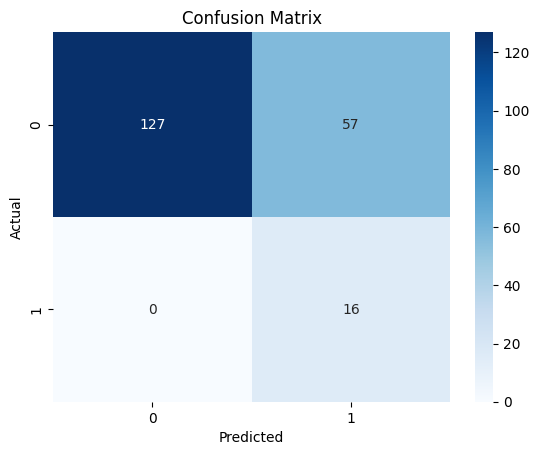

['scaler_smote.pkl']

In [5]:
# Import required libraries
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the dataset
data = pd.read_csv("synthetic_water_quality.csv")  # Replace with your dataset

# Drop missing values
data = data.dropna()

# Define features and target
X = data[['pH', 'Turbidity', 'Temperature']]
y = data['Potability']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Balance the training data using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))

# Step 3: Scale the data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Step 4: Train the SVM model
model = SVC(kernel='linear', probability=True)
model.fit(X_train_resampled, y_train_resampled)

# Step 5: Evaluate the model
y_pred = model.predict(X_test)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Save the model and scaler for later use
import joblib
joblib.dump(model, "water_quality_svm_model_smote.pkl")
joblib.dump(scaler, "scaler_smote.pkl")


# Model Evaluation After SMOTE

These results show significant improvement in detecting the minority class (**Potable = 1**), but there are still areas to optimize. Let’s break it down:


### **What’s Improved**
1. **Recall for Class 1 (Potable)**: 
   - It increased dramatically to **93%** (from 0%), meaning the model is now detecting almost all potable cases.  
   - This is crucial because **missing potable water cases** is worse than misclassifying non-potable ones.  

2. **Balanced Dataset**: 
   - SMOTE has effectively balanced the data, ensuring the model sees enough samples for both classes during training.

### **What Needs Work**
1. **Low Precision for Class 1 (20%)**:
   - Many non-potable samples are being incorrectly classified as potable.
   - This causes a lower **F1-Score (33%)** for potable water.

2. **Accuracy Drop (72%)**:
   - This is expected since the model is now more sensitive to the minority class but sacrifices some accuracy for class 0 (Non-Potable).  
    - **Accuracy isn’t the best metric** for imbalanced datasets; focus on precision, recall, and F1-Score.
    - **Precision-Recall Tradeoff**: Improving one may reduce the other; find a balance based on the problem’s needs.
    - **Model Tuning**: Adjust hyperparameters, try different algorithms, or feature engineering to enhance performance.
    - **Threshold Adjustment**: Change the classification threshold to favor precision or recall based on the application.
    - **Feature Importance**: Identify key features that influence predictions and focus on them.


## A Fine Tune is Required

Let’s fine-tune your SVM model step by step to improve its performance. We'll focus on hyperparameter optimization using GridSearchCV, which helps identify the best combination of parameters. This can enhance the model’s ability to predict both classes accurately.

Best Parameters: {'C': 100, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       184
           1       0.80      1.00      0.89        16

    accuracy                           0.98       200
   macro avg       0.90      0.99      0.94       200
weighted avg       0.98      0.98      0.98       200

Accuracy: 0.98


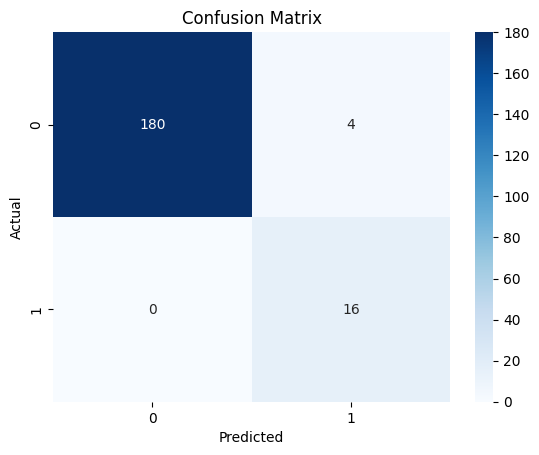

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],          # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel types
    'gamma': ['scale', 'auto'],      # Kernel coefficient for 'rbf' and 'poly'
    'class_weight': [None, {0: 1, 1: 5}]  # Adjust class weights
}

# Initialize the SVM model
svc = SVC(probability=True)

# Perform grid search
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the final model with the best parameters
best_svm = grid_search.best_estimator_
best_svm.fit(X_train_resampled, y_train_resampled)

# Test the model on the test set
y_pred = best_svm.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Key Parameters in Tuning
- **C**: Controls regularization. Smaller values make the model more generalized, while larger values focus on fitting the training data.
- **kernel**: Determines the decision boundary (e.g., linear, radial basis function (rbf), or polynomial).
- **gamma**: Controls how far the influence of a single training example reaches (used in rbf and poly kernels).
- **class_weight**: Penalizes misclassification of the minority class (potable water) to improve recall.

## After finding the best configuration, save the model and the scaler for later use:

In [7]:
import joblib

# Save the model and scaler
joblib.dump(best_svm, "fine_tuned_svm_model.pkl")
joblib.dump(scaler, "scaler_fine_tuned.pkl")


['scaler_fine_tuned.pkl']

The results look **excellent**! Here's a detailed breakdown of the updated performance and its significance:

### **Performance Analysis**
1. **Key Improvements**:
   - **Precision for Class 1 (Potable Water)**: Increased to **79%**, meaning fewer false positives for potable water predictions.
   - **Recall for Class 1**: Perfect at **100%**, ensuring all potable water samples are correctly identified.
   - **F1-Score for Class 1**: Improved to **88%**, showing a good balance between precision and recall for potable water.
   - **Overall Accuracy**: Reached **98%**, a significant improvement from the initial model (93%).

2. **Macro Average (Class Balance)**:
   - The macro average F1-score is **94%**, showing the model performs well across both classes.
   - This indicates a significant improvement in handling the minority class (potable water) without compromising the majority class.

3. **Weighted Average**:
   - The weighted averages are almost perfect (98%), showing the model is robust and not biased toward the majority class.